In [3]:
!pip install numpy pandas tensorflow matplotlib


In [4]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 32.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def calculate_foot_angle(heel, toe):
    foot_vector = np.array(toe) - np.array(heel)
    floor_vector = np.array([1, 0])  # Horizontal line
    foot_vector_normalized = foot_vector / np.linalg.norm(foot_vector)
    floor_vector_normalized = floor_vector / np.linalg.norm(floor_vector)
    angle = np.arccos(np.clip(np.dot(foot_vector_normalized, floor_vector_normalized), -1.0, 1.0))
    return np.degrees(angle)

def draw_foot_info(image, heel, toe, angle, distance_text=None):
    cv2.circle(image, heel, 5, (255, 0, 0), -1)
    cv2.circle(image, toe, 5, (0, 255, 0), -1)
    cv2.line(image, heel, toe, (0, 0, 255), 2)
    text_pos = (heel[0], heel[1] - 10)
    cv2.putText(image, f"Angle: {angle:.2f} deg", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    if distance_text:
        cv2.putText(image, f"Dist: {distance_text:.2f} px", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

def get_landmarks(landmarks, frame_shape):
    left_heel = (int(landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x * frame_shape[1]),
                 int(landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y * frame_shape[0]))
    left_toe = (int(landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x * frame_shape[1]),
                int(landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y * frame_shape[0]))
    right_heel = (int(landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x * frame_shape[1]),
                  int(landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y * frame_shape[0]))
    right_toe = (int(landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x * frame_shape[1]),
                 int(landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y * frame_shape[0]))
    return left_heel, left_toe, right_heel, right_toe

input_dir = '/content/drive/MyDrive/4steps/frames2'
output_dir = '/content/drive/MyDrive/4steps/testroi3'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
all_data_csv_path = os.path.join(output_dir, 'all_class_foot_data.csv')

# Prepare a single CSV file for all data
with open(all_data_csv_path, 'w', newline='') as all_data_csv_file:
    all_data_csv_writer = csv.writer(all_data_csv_file)
    all_data_csv_writer.writerow(['Class', 'Frame', 'Left_Foot_Angle', 'Right_Foot_Angle', 'Distance_Between_Feet'])

    # Process each class directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        frame_files = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        frame_index = 0

        for frame_file in frame_files:
            frame_path = os.path.join(class_dir, frame_file)
            frame = cv2.imread(frame_path)
            if frame is None:
                print(f"Error reading frame {frame_file}")
                continue

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                left_heel, left_toe, right_heel, right_toe = get_landmarks(landmarks, frame.shape)
                distance = np.linalg.norm(np.array(left_heel) - np.array(right_heel))
                left_angle = calculate_foot_angle(left_heel, left_toe)
                right_angle = calculate_foot_angle(right_heel, right_toe)

                # Write data to the single CSV file
                all_data_csv_writer.writerow([class_name, frame_index, left_angle, right_angle, distance])
                draw_foot_info(image, left_heel, left_toe, left_angle, distance_text=distance)
                draw_foot_info(image, right_heel, right_toe, right_angle)

                # Save processed frame
                processed_frame_path = os.path.join(output_dir, f'{class_name}_frame_{frame_index:04d}.jpg')
                cv2.imwrite(processed_frame_path, image)

                plt.figure(figsize=(8, 8))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f"Frame {frame_index} - {class_name}")
                plt.axis('off')
                plt.show()

                frame_index += 1

print(f"All classes processed and data saved in '{all_data_csv_path}'")


Output hidden; open in https://colab.research.google.com to view.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/dataset5/frm45_pro/all_class_pose_data.csv')

# Define the feature columns and the target columns
feature_columns = ['Left_Foot_Angle', 'Right_Foot_Angle', 'Distance_Between_Feet', 'Left_Arm_Angle', 'Right_Arm_Angle']
targets = ['Left_Foot_Angle', 'Right_Foot_Angle', 'Distance_Between_Feet', 'Left_Arm_Angle', 'Right_Arm_Angle']  # Adjust if your targets are different

# Prepare features (X) and targets (y)
X = data[feature_columns]
y = data[targets]

# We need to ensure that we stratify by class. For stratification, a single column is needed, hence we'll use 'Class'
class_labels = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=class_labels, random_state=42)

# Optionally, verify the stratification and the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Save the splits to new CSV files for future use
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('/content/drive/MyDrive/dataset5/train_test/frm45_train.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/dataset5/train_test/frm45_test.csv', index=False)

print("Data has been split and saved into training and testing CSV files.")


Training set size: 467 samples
Testing set size: 117 samples
Data has been split and saved into training and testing CSV files.


In [6]:
import numpy as np
import pandas as pd

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Here we're extracting sequences of length n_steps for features
        X.append(data.iloc[i:(i + n_steps), :-3].values)
        # Assuming the last three columns are the target values and we're predicting the next step
        y.append(data.iloc[i + n_steps, -3:].values)
    return np.array(X), np.array(y)

# Load your training and testing datasets
train_data = pd.read_csv('/content/drive/MyDrive/dataset5/train_test/frm45_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/dataset5/train_test/frm45_test.csv')

# Number of timesteps in the input sequence
n_steps = 5  # You can adjust this based on your specific needs

# Generate sequences for training data
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

# Example output
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (462, 5, 7)
y_train shape: (462, 3)
X_test shape: (112, 5, 7)
y_test shape: (112, 3)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(500, activation='relu', input_shape=(5, 7)),  # 1000 LSTM units, input_shape matches the X_train shape [timesteps, features]
    Dense(3)  # Output layer with 3 units, one for each predicted feature
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Save the model if needed
model.save('/content/drive/MyDrive/dataset5/models/my_lstm_model_45.h5')


Epoch 1/50
15/15 [==============================] - 6s 50ms/step - loss: 5142.3188 - accuracy: 0.6126 - val_loss: 2309.0662 - val_accuracy: 0.6875
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 2040.6410 - accuracy: 0.6905 - val_loss: 2182.9333 - val_accuracy: 0.6875
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 2007.4078 - accuracy: 0.6926 - val_loss: 2157.1372 - val_accuracy: 0.6964
Epoch 4/50
15/15 [==============================] - 0s 11ms/step - loss: 2000.6086 - accuracy: 0.5887 - val_loss: 2123.3013 - val_accuracy: 0.6875
Epoch 5/50
15/15 [==============================] - 0s 11ms/step - loss: 1923.6149 - accuracy: 0.6926 - val_loss: 2134.5776 - val_accuracy: 0.6875
Epoch 6/50
15/15 [==============================] - 0s 11ms/step - loss: 1916.4709 - accuracy: 0.6926 - val_loss: 2532.8572 - val_accuracy: 0.6696
Epoch 7/50
15/15 [==============================] - 0s 11ms/step - loss: 1959.8873 - accuracy: 0.6905 - val_loss: 2201

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


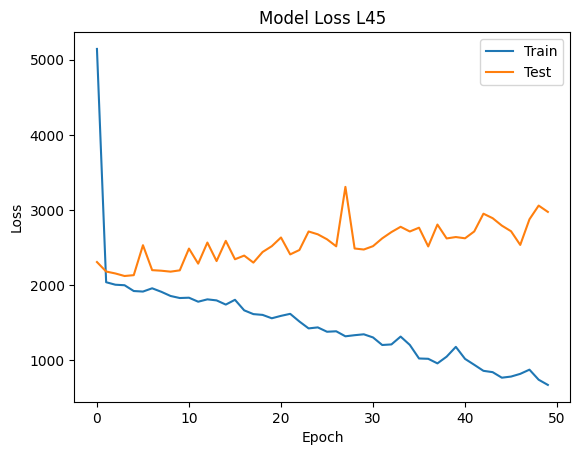

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss L45')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Save the figure
plt.savefig('/content/drive/MyDrive/dataset5/models/model_loss_plot_45.png')  # Saves the plot as a PNG file
# plt.savefig('model_loss_plot.pdf')  # Uncomment this line to save as a PDF instead

# Display the plot
plt.show()


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential([
    LSTM(1000, activation='relu', input_shape=(5, 7)),  # 1000 LSTM units, input_shape matches the X_train shape [timesteps, features]
    Dense(3)  # Output layer with 3 units, one for each predicted feature
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the model if needed
model.save('/content/drive/MyDrive/dataset5/models/my_lstm_model_45_1.h5')


Epoch 1/50
15/15 [==============================] - 2s 31ms/step - loss: 5050.0269 - accuracy: 0.6840 - val_loss: 3106.0486 - val_accuracy: 0.6875
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 2246.8682 - accuracy: 0.5563 - val_loss: 2402.2380 - val_accuracy: 0.6875
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 2089.2852 - accuracy: 0.6926 - val_loss: 2272.2852 - val_accuracy: 0.6875
Epoch 4/50
15/15 [==============================] - 0s 14ms/step - loss: 2010.4658 - accuracy: 0.6926 - val_loss: 2226.1812 - val_accuracy: 0.6875
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 2027.9346 - accuracy: 0.6905 - val_loss: 2177.2490 - val_accuracy: 0.6875
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 1998.8311 - accuracy: 0.6948 - val_loss: 2137.0234 - val_accuracy: 0.6875
Epoch 7/50
15/15 [==============================] - 0s 12ms/step - loss: 2004.2772 - accuracy: 0.6926 - val_loss: 2162

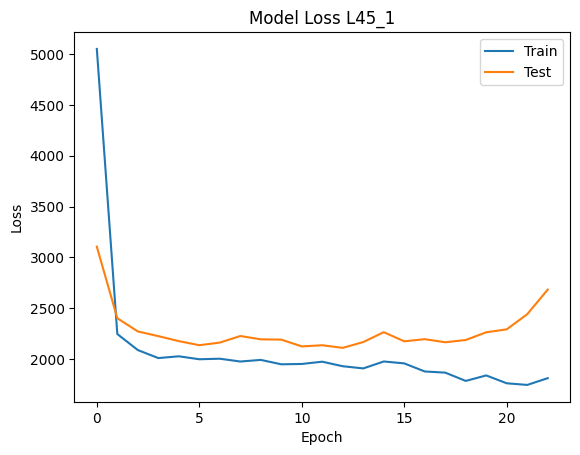

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss L45_1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Save the figure
plt.savefig('/content/drive/MyDrive/dataset5/models/model_loss_plot_45_1.png')  # Saves the plot as a PNG file
# plt.savefig('model_loss_plot.pdf')  # Uncomment this line to save as a PDF instead

# Display the plot
plt.show()


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model with an additional LSTM layer
model = Sequential([
    LSTM(1000, activation='relu', return_sequences=True, input_shape=(5, 7)),  # First LSTM layer
    LSTM(500, activation='relu'),  # Second LSTM layer with 500 units
    Dense(50, activation='relu'),  # Adding a Dense layer to help learn complex features
    Dense(3, activation='softmax')  # Output layer with 3 units, one for each predicted feature
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the model if needed
model.save('/content/drive/MyDrive/dataset5/models/my_lstm_model_45_1.h5')


Epoch 1/50
15/15 [==============================] - 4s 56ms/step - loss: 19149.1484 - accuracy: 0.2186 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 19148.0117 - accuracy: 0.2208 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 19148.0137 - accuracy: 0.2208 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 4/50
15/15 [==============================] - 0s 22ms/step - loss: 19148.0137 - accuracy: 0.2208 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 5/50
15/15 [==============================] - 0s 23ms/step - loss: 19148.0156 - accuracy: 0.2208 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 6/50
15/15 [==============================] - 0s 23ms/step - loss: 19148.0137 - accuracy: 0.2208 - val_loss: 17899.8555 - val_accuracy: 0.2411
Epoch 7/50
15/15 [==============================] - 1s 35ms/step - loss: 19148.0137 - accuracy: 0.2208 - v

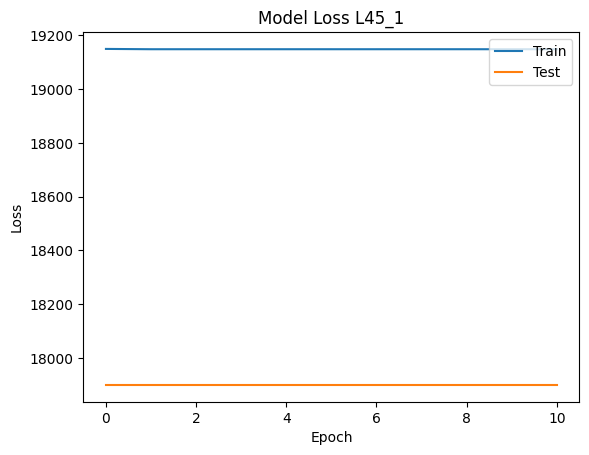

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss L45_1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# Display the plot
plt.show()
